In [3]:
from typing import Any
import random
import os

import numpy as np

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import ToTensor

from validation_model import FaceValidateV1
from settings import *
from avapix.avapix_loss import AvapixLoss
from avapix.avapix_model import AvapixModel
import avapix.avapix_utils as utils

In [4]:
DEVICE = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)

print (f'Using device: {DEVICE}')

Using device: cuda


In [212]:
class EmbeddedFacesDataset(Dataset):
    def __init__(self, images, gen_per_image) -> None:
        super().__init__()

        self.transform = ToTensor()

        self.images = images.copy()
        self.gen_per_image = gen_per_image

        self.random_lengths = []
        self.curr_image_tensor = None

    def __getitem__(self, index) -> Any:
        if index % self.gen_per_image == 0:
            self.random_lengths = list(range(128))
            random.shuffle(self.random_lengths)

            curr_image = self.images[index // self.gen_per_image]
            self.curr_image_tensor = self.transform(
                Image.open(curr_image)).to(DEVICE)

        curr_rand_len = self.random_lengths.pop()

        output_img = utils.generate_input_v1(self.curr_image_tensor,
                                             DEFAULT_RANDOM_SEED,
                                             curr_rand_len)
        output_img = output_img.reshape((3, 8, 8))

        return output_img

    def __len__(self):
        return len(self.images) * self.gen_per_image


In [286]:
import importlib
import avapix.avapix_model
import avapix.avapix_loss
import avapix.avapix_utils
importlib.reload(avapix.avapix_model)
importlib.reload(avapix.avapix_loss)
importlib.reload(avapix.avapix_utils)
from avapix.avapix_model import AvapixModel
from avapix.avapix_loss import AvapixLoss
import avapix.avapix_utils as utils

In [287]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
NUM_EPOCHS = 20
GEN_PER_IMAGE = 10

image_list = os.listdir(VALID_FACE_DIR)
image_list = [os.path.join(VALID_FACE_DIR, img_file) for img_file in image_list]

dataset = EmbeddedFacesDataset(image_list, GEN_PER_IMAGE)
dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=False)

model = AvapixModel(DEVICE)

criterion = AvapixLoss(DEVICE)
mse_loss = nn.MSELoss()

loss_model = FaceValidateV1(DEVICE)
loss_model.load_state_dict(torch.load('./assets/validation_model.pth'))

optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE,
                             weight_decay=1e-4)

In [288]:
losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0.0

    for batch_imgs in dataloader:
        
        optimizer.zero_grad()
        outputs = model(batch_imgs)

        possibility_pred = loss_model(outputs)
        
        loss = criterion(possibility_pred)
        # loss = mse_loss(loss, torch.zeros(loss.shape[0]).to(DEVICE))
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)

    if epoch % 10 == 9:
        print(f"Epoch {epoch+1:03d}/{NUM_EPOCHS} - Loss: {avg_loss:.4f}", end='\t')
        if (epoch + 1) % 20 == 0:
            print()

print("Training complete.")

Epoch 010/20 - Loss: 1.2691	Epoch 020/20 - Loss: 1.2625	
Training complete.


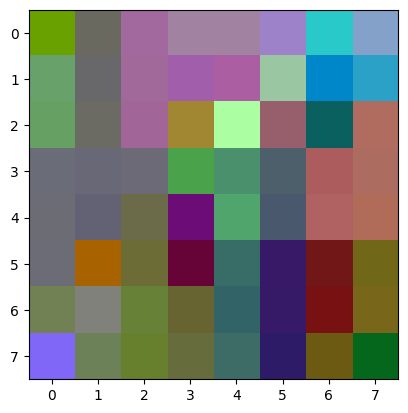

In [290]:
_ = outputs[15]
_ = _.detach().cpu().numpy().reshape((8,8,3))
plt.imshow(_)

In [295]:
_ = utils.embed_raw_img_v1('', 42).to(DEVICE) / 255
_ = _.reshape((3, 8, 8))
_ = _.unsqueeze(0)

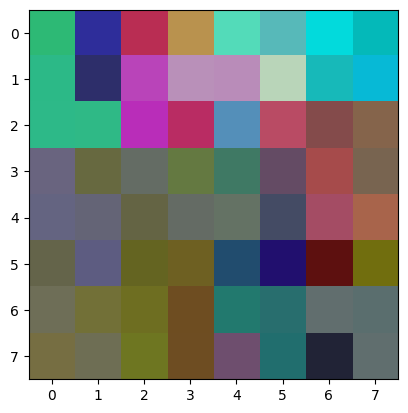

In [296]:
i_ = model(_)
plt.imshow(i_.detach().cpu().numpy().reshape((8, 8, 3)))

In [297]:
loss_model(i_)

tensor([[0.7263]], device='cuda:0', grad_fn=<SigmoidBackward0>)